In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42

import python_code.Scripts as sc
import python_code.Reference as ref
import pickle

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
from treeinterpreter import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("./data/final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SHELDED   3904 non-null   float64
 1   FSSTDDE2  3904 non-null   float64
 2   FSTOTDED  3904 non-null   float64
 3   HWGT      3904 non-null   float64
 4   FSGRINC   3904 non-null   float64
 5   FSSSI     3904 non-null   float64
 6   LIQRESOR  3904 non-null   float64
 7   FSNELDER  3904 non-null   float64
 8   FSGA      3904 non-null   float64
 9   RAWNET    3904 non-null   float64
 10  FSNONCIT  3904 non-null   float64
 11  FSEARN    3904 non-null   float64
 12  FSUNEARN  3904 non-null   float64
 13  FSTOTDE2  3904 non-null   float64
 14  FSSLTDE2  3904 non-null   float64
 15  FSERNDE2  3904 non-null   float64
 16  FSUSIZE   3904 non-null   float64
 17  FSNETINC  3904 non-null   float64
 18  FSERNDED  3904 non-null   float64
 19  WRK_POOR  3904 non-null   float64
 20  FSASSET   3904 non-null   floa

In [4]:
X = df.drop(columns = ['CAT_ELIG'])
y = df['CAT_ELIG']

In [5]:
#baseline, NULL Model
y.value_counts(normalize=True)

CAT_ELIG
1.0    0.662398
0.0    0.337602
Name: proportion, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
np.savetxt('./data/TrainTest/X_train.csv',X_train,delimiter=',')
np.savetxt('./data/TrainTest/y_train.csv',y_train,delimiter=',')
np.savetxt('./data/TrainTest/X_test.csv',X_test,delimiter=',')
np.savetxt('./data/TrainTest/y_test.csv',y_test,delimiter=',')

In [9]:
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [10]:
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [12]:
#adapted from Dan Brown lecture
final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        final = pd.concat([final, pd.DataFrame([results])], ignore_index=True)
        idx+=1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_1492\3752060610.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, pd.DataFrame([results])], ignore_index=True)


In [13]:
final = final.set_index('name')
final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.885798,0.862628,0.897638,0.898817
Decision Tree,0.912518,0.919795,0.929134,0.926702
Random Forest,0.942899,0.936860,0.964567,0.954545
Gradient Boost,0.940703,0.930887,0.960630,0.954368
Ada Boost,0.879941,0.882253,0.910761,0.906005
SVC,0.885432,0.857509,0.902887,0.923490
Naive Bayes,0.770498,0.744881,0.829396,0.911977


In [14]:
pc_final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train_pc, y_train)
        y_pred_train = model.predict(X_train_pc)
        y_pred_test = model.predict(X_test_pc)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        pc_final = pd.concat([pc_final, pd.DataFrame([results])], ignore_index=True)
        idx+=1

C:\Users\Daniel\AppData\Local\Temp\ipykernel_1492\2782522977.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pc_final = pd.concat([pc_final, pd.DataFrame([results])], ignore_index=True)


In [15]:
pc_final = pc_final.set_index('name')
pc_final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.792826,0.773038,0.895013,0.787529
Decision Tree,0.843338,0.793515,0.914698,0.867995
Random Forest,0.887262,0.862628,0.935696,0.897985
Gradient Boost,0.876647,0.858362,0.916010,0.882427
Ada Boost,0.841874,0.814846,0.896325,0.856964
SVC,0.836750,0.837884,0.871391,0.875989
Naive Bayes,0.728770,0.712457,0.956693,0.693625


In [16]:
for name,model in models.items():
    name = model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred_test))
    print('\n')

LogisticRegression()
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       410
         1.0       0.90      0.90      0.90       762

    accuracy                           0.87      1172
   macro avg       0.85      0.85      0.85      1172
weighted avg       0.87      0.87      0.87      1172



DecisionTreeClassifier()
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87       410
         1.0       0.93      0.94      0.93       762

    accuracy                           0.91      1172
   macro avg       0.91      0.90      0.90      1172
weighted avg       0.91      0.91      0.91      1172



RandomForestClassifier()
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       410
         1.0       0.95      0.96      0.96       762

    accuracy                           0.94      1172
   macro avg       0.94      0.94      0.94      1172

In [17]:
rf = RandomForestClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'sqrt'],
       'n_estimators':[75,100,125]}
rf_gs = GridSearchCV(rf,param_grid=params)
rf_gs.fit(X_train,y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.945461424620474


{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 125}

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [19]:
instances = X_test[[735]]
instances

array([[ 1.00652396, -1.59315573,  0.39411313, -0.51614194, -1.25472977,
        -0.42833737, -0.24501332, -0.40909055, -0.1335093 , -0.88061189,
         1.78070948, -0.59800159, -0.91848291, -1.28640995, -0.87253073,
        -0.56404251,  1.02614408, -0.8826584 , -0.59758589, -0.76825854,
        -0.24309398, -0.55893964, -0.03517855, -0.59885312,  1.0459183 ,
        -1.49056789, -0.51403261, -0.34230342,  1.02614408, -0.36488324,
        -0.02833014, -0.42334304]])

In [20]:
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.71 0.29]]
Bias (trainset prior) [[0.33176794 0.66823206]]
Feature contributions:
SHELDED [ 0.14274449 -0.14274449]
FSSTDDE2 [ 0.03200668 -0.03200668]
FSTOTDED [-0.06134962  0.06134962]
HWGT [ 0.06711859 -0.06711859]
FSGRINC [ 0.00744811 -0.00744811]
FSSSI [ 0.01087408 -0.01087408]
LIQRESOR [-0.02099727  0.02099727]
FSNELDER [ 0.00046244 -0.00046244]
FSGA [ 0.00229025 -0.00229025]
RAWNET [-0.00074603  0.00074603]
FSNONCIT [-0.00303223  0.00303223]
FSEARN [-0.01440121  0.01440121]
FSUNEARN [ 0.02784819 -0.02784819]
FSTOTDE2 [ 0.01582969 -0.01582969]
FSSLTDE2 [ 0.0045216 -0.0045216]
FSERNDE2 [-0.00399758  0.00399758]
FSUSIZE [ 0.0359158 -0.0359158]
FSNETINC [-0.00953511  0.00953511]
FSERNDED [-0.00548728  0.00548728]
WRK_POOR [-0.00858997  0.00858997]
FSASSET [-0.02843475  0.02843475]
FSWAGES [-0.0040524  0.0040524]
REALPROP [0. 0.]
RAWERND [-0.00627052  0.00627052]
FSSLTDED [ 0.10842468 -0.10842468]
TPOV [-0.01407825  0.01407825]
FSDIS [-0.00012495  0.00012495]
FSTANF [ 0.

In [21]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv('./data/2018_indicators/coef.csv',index=None)

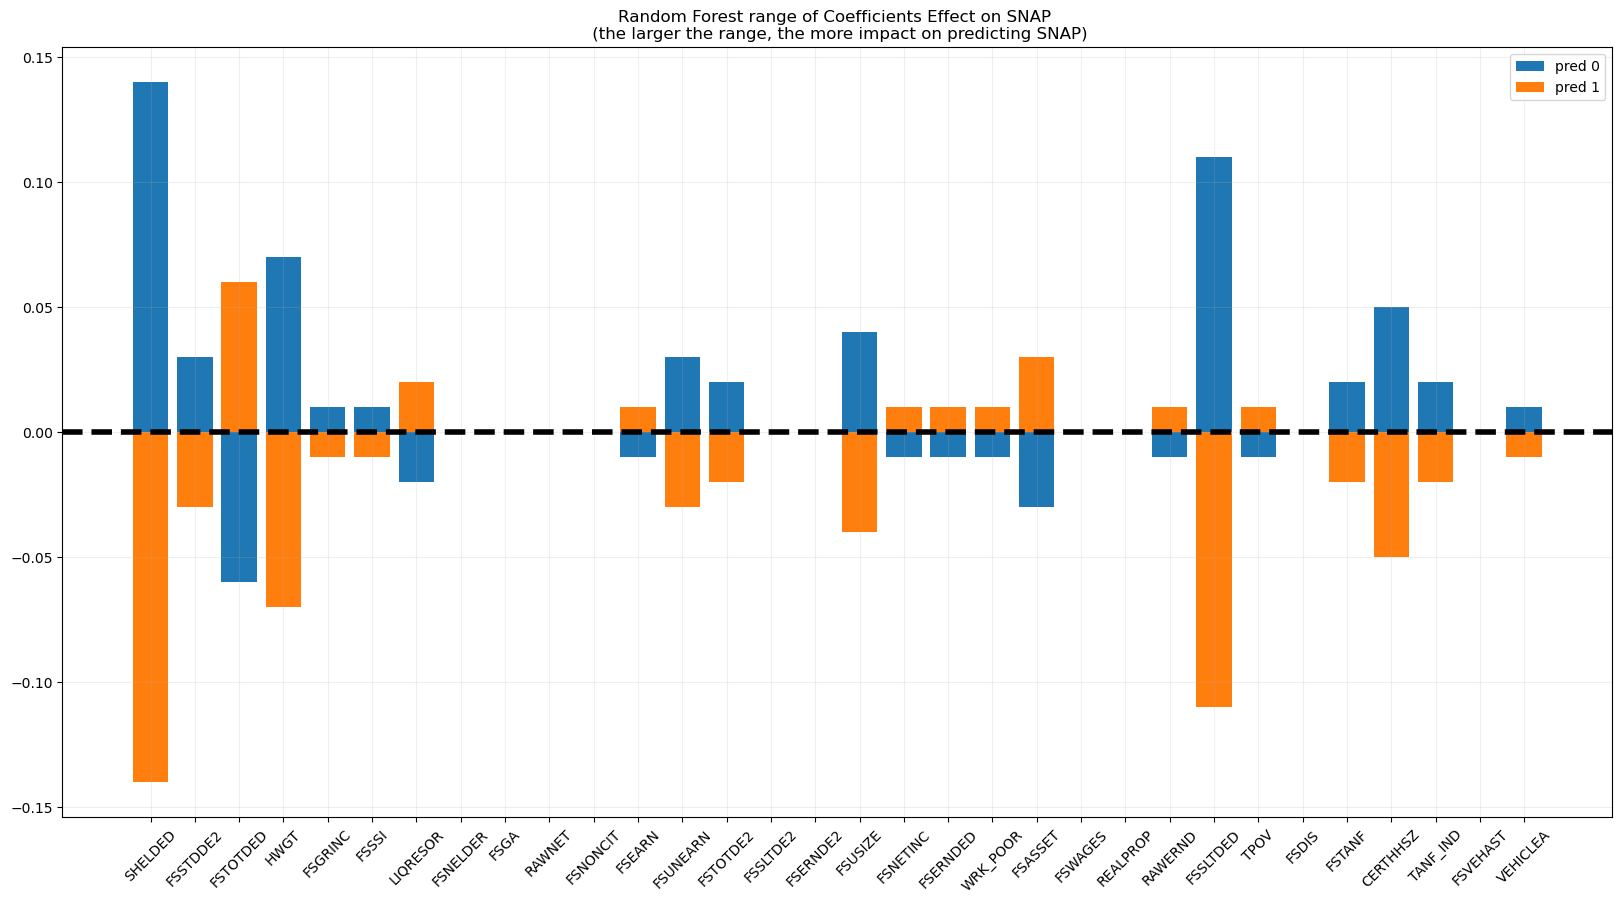

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig('./images/rf_corr.png');

In [23]:
et = ExtraTreeClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'sqrt'],
       'max_leaf_nodes':[5,10]}
et_gs = GridSearchCV(et,param_grid=params)
et_gs.fit(X_train,y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.8342018736899908


{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10}

In [24]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.728770131771596
cross_val_test = 0.7124573378839589
test_recall = 0.9619422572178478
test_precision = 0.9606815203145478


In [25]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [26]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [27]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))